In [41]:
"""
Registration

https://github.com/nipy/dipy/blob/master/dipy/workflows/align.py
https://github.com/nipy/nipype/blob/master/nipype/interfaces/dipy/preprocess.py

https://nipype.readthedocs.io/en/latest/users/examples/workflow_from_scratch.html
https://miykael.github.io/nipype_tutorial/notebooks/advanced_create_interfaces.html

http://nipy.org/dipy/examples_built/affine_registration_3d.html

https://github.com/jrudascas/ConnectivityTrack/blob/master/core.py
https://github.com/jscanass/Tractos/blob/master/affine_reg.py



http://nipy.org/dipy/examples_built/workflow_creation.html#example-workflow-creation
https://github.com/nipy/nipype/tree/master/nipype/interfaces/dipy
http://nipy.org/dipy/devel/index.html

https://bic-berkeley.github.io/psych-214-fall-2016/dipy_registration.html
https://grg.sice.indiana.edu/blog/2018/1/19/how-to-contribute-to-dipy/
"""

'\nRegistration\n\nhttps://github.com/nipy/dipy/blob/master/dipy/workflows/align.py\nhttps://github.com/nipy/nipype/blob/master/nipype/interfaces/dipy/preprocess.py\n\nhttps://nipype.readthedocs.io/en/latest/users/examples/workflow_from_scratch.html\nhttps://miykael.github.io/nipype_tutorial/notebooks/advanced_create_interfaces.html\n\nhttp://nipy.org/dipy/examples_built/affine_registration_3d.html\n\nhttps://github.com/jrudascas/ConnectivityTrack/blob/master/core.py\nhttps://github.com/jscanass/Tractos/blob/master/affine_reg.py\n\n\n\nhttp://nipy.org/dipy/examples_built/workflow_creation.html#example-workflow-creation\nhttps://github.com/nipy/nipype/tree/master/nipype/interfaces/dipy\nhttp://nipy.org/dipy/devel/index.html\n\nhttps://bic-berkeley.github.io/psych-214-fall-2016/dipy_registration.html\nhttps://grg.sice.indiana.edu/blog/2018/1/19/how-to-contribute-to-dipy/\n'

In [42]:
import numpy as np

from dipy.viz import regtools 

from dipy.data import fetch_stanford_hardi, read_stanford_hardi
from dipy.data.fetcher import fetch_syn_data, read_syn_data

from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)

In [43]:

#static image
fetch_stanford_hardi()
nib_stanford, gtab_stanford = read_stanford_hardi()
static = np.squeeze(nib_stanford.get_data())[..., 0]
static_grid2world = nib_stanford.affine

Dataset is already in place. If you want to fetch it again please first remove the folder /home/jscanass/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /home/jscanass/.dipy/stanford_hardi 


In [44]:
#moving image
fetch_syn_data()
nib_syn_t1, nib_syn_b0 = read_syn_data()
moving = np.array(nib_syn_b0.get_data())
moving_grid2world = nib_syn_b0.affine

Data size is approximately 12MB
Dataset is already in place. If you want to fetch it again please first remove the folder /home/jscanass/.dipy/syn_test 
Data size is approximately 12MB
Dataset is already in place. If you want to fetch it again please first remove the folder /home/jscanass/.dipy/syn_test 


In [48]:
type(moving_grid2world)

numpy.ndarray

In [45]:
input_t1 = "/home/jscanass/brain/data/candela/Benhammou_S/T1w_nipype_bet.nii.gz"

In [46]:
identity = np.eye(4)
affine_map = AffineMap(identity,
                       static.shape, static_grid2world,
                       moving.shape, moving_grid2world)
resampled = affine_map.transform(moving)

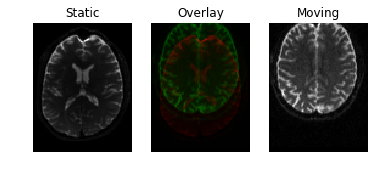

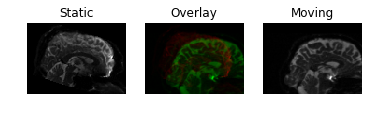

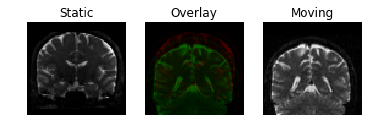

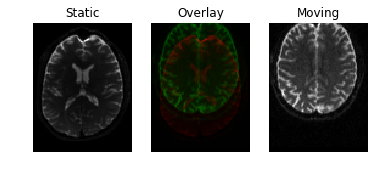

In [7]:
regtools.overlay_slices(static, resampled, None, 0,
                        "Static", "Moving", "resampled_0.png")
regtools.overlay_slices(static, resampled, None, 1,
                        "Static", "Moving", "resampled_1.png")
regtools.overlay_slices(static, resampled, None, 2,
                        "Static", "Moving", "resampled_2.png")

In [8]:
c_of_mass = transform_centers_of_mass(static, static_grid2world,
                                      moving, moving_grid2world)

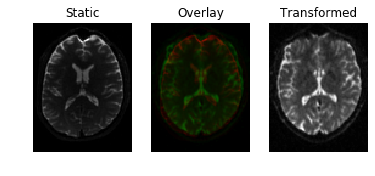

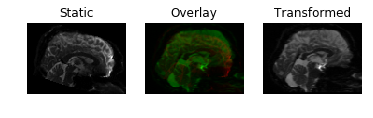

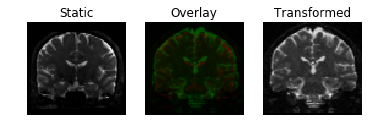

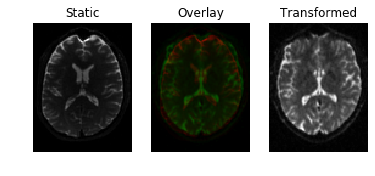

In [9]:
transformed = c_of_mass.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_com_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_com_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_com_2.png")

In [34]:
np.shape(moving)

(128, 128, 75)

In [10]:
np.shape(transformed)

(81, 106, 76)

In [11]:
#affine transform
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)

level_iters = [10000, 1000, 100]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]

affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

In [12]:
transform = TranslationTransform3D()
params0 = None
starting_affine = c_of_mass.affine
translation = affreg.optimize(static, moving, transform, params0,
                              static_grid2world, moving_grid2world,
                              starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


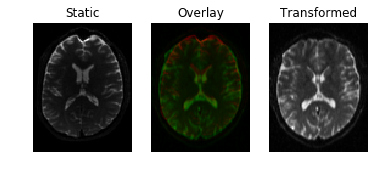

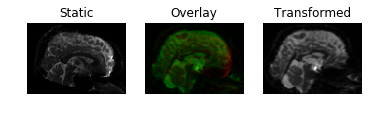

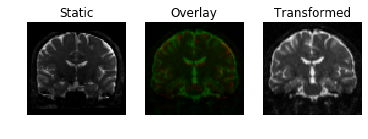

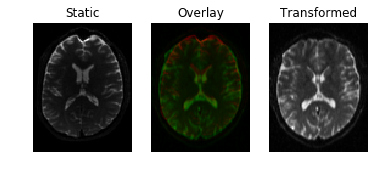

In [13]:
transformed = translation.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_trans_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_trans_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_trans_2.png")

In [14]:
transform = RigidTransform3D()
params0 = None
starting_affine = translation.affine
rigid = affreg.optimize(static, moving, transform, params0,
                        static_grid2world, moving_grid2world,
                        starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


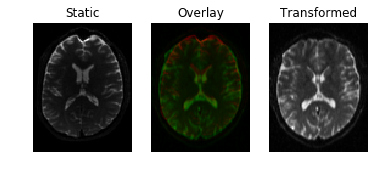

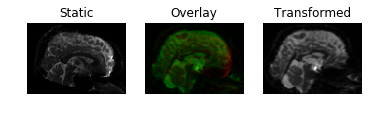

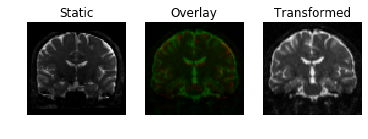

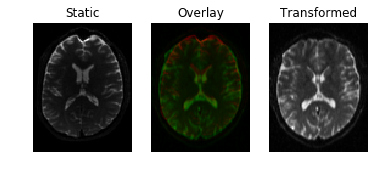

In [15]:
transformed = translation.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_trans_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_trans_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_trans_2.png")

In [16]:
transform = AffineTransform3D()
params0 = None
starting_affine = rigid.affine
affine = affreg.optimize(static, moving, transform, params0,
                         static_grid2world, moving_grid2world,
                         starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [36]:
type(affine)

dipy.align.imaffine.AffineMap

In [39]:
affine

array([[ 1.02771577e+00, -2.42263532e-02, -3.43958376e-02,
        -3.16034218e+00],
       [-2.13251423e-02,  9.30340500e-01, -3.00321146e-01,
         3.22703010e+01],
       [ 3.14152601e-02,  3.14889771e-01,  9.81215959e-01,
        -1.45055507e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

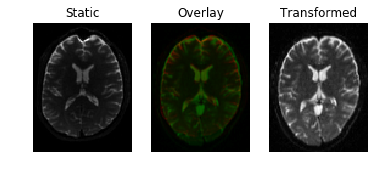

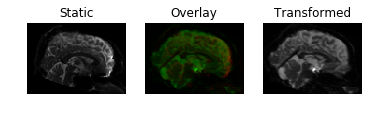

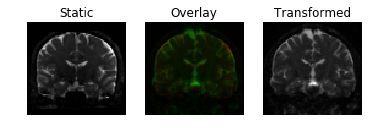

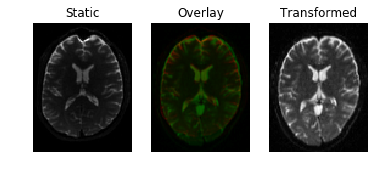

In [40]:
transformed = affine.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_affine_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_affine_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_affine_2.png")

In [18]:
import time
import matplotlib.pyplot as plt

%matplotlib inline

def Registration(static,moving,nbins=32,sampling_prop=None,
                 metric=MutualInformationMetric(nbins, sampling_prop),
                 level_iters=[10000, 1000, 100],
                 sigmas=[3.0, 1.0, 0.0],
                 factors=[4, 2, 1]):
    
    """
    
    static and moving = nifti files converted to matrix
    
    """
    t0_time = time.time()

    print('---> I. Translation of the moving image towards the static image')

    #condition if we have a path or a nifti file

    static_img = nib.load(static_path)
    static = static_img.get_data()
    static_grid2world = static_img.affine

    moving_img = nib.load(moving_path)
    moving = np.array(moving_img.get_data())[..., 0]
    moving_grid2world = moving_img.affine

    # resample for have the same number of voxels
    
    print('---> Resembling the moving image on a grid of the same dimensions as the static image')
    
    identity = np.eye(4)
    affine_map = AffineMap(identity,
                       static.shape, static_grid2world,
                       moving.shape, moving_grid2world)
    resampled = affine_map.transform(moving)
    regtools.overlay_slices(static, resampled, None, 0,
                        "Static", "Moving", "resampled_0.png")


    regtools.overlay_slices(static, resampled, None, 1,
                        "Static", "Moving", "resampled_1.png")


    regtools.overlay_slices(static, resampled, None, 2,
                        "Static", "Moving", "resampled_2.png")
    plt.show()

    #centers of mass registration
    
    print('---> Aligning the centers of mass of the two images')
    
    c_of_mass = transform_centers_of_mass(static, static_grid2world,
                                      moving, moving_grid2world)
    transformed = c_of_mass.transform(moving)
    
    regtools.overlay_slices(static, transformed, None, 0,
                            "Static", "Transformed", "transformed_com_0.png")
    regtools.overlay_slices(static, transformed, None, 1,
                            "Static", "Transformed", "transformed_com_1.png")
    regtools.overlay_slices(static, transformed, None, 2,
                            "Static", "Transformed", "transformed_com_2.png")
    plt.show()

    
    print('---> II. Refine  by looking for an affine transform')
    
    #affine transform
    nbins = 32
    sampling_prop = None
    metric = MutualInformationMetric(nbins, sampling_prop)


    level_iters = [10000, 1000, 100]
    sigmas = [3.0, 1.0, 0.0]
    factors = [4, 2, 1]
    
    print('---> Computing Affine Registration (non-convex optimization)')
    
    affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)
    
    transform = TranslationTransform3D()
    params0 = None
    starting_affine = c_of_mass.affine
    translation = affreg.optimize(static, moving, transform, params0,
                                  static_grid2world, moving_grid2world,
                                  starting_affine=starting_affine)
    
    transformed = translation.transform(moving)
    regtools.overlay_slices(static, transformed, None, 0,
                            "Static", "Transformed", "transformed_trans_0.png")
    regtools.overlay_slices(static, transformed, None, 1,
                            "Static", "Transformed", "transformed_trans_1.png")
    regtools.overlay_slices(static, transformed, None, 2,
                            "Static", "Transformed", "transformed_trans_2.png")  
    plt.show()

    
    print('--->III. Refining with a rigid transform')
    
    #rigid transform 
    
    transform = RigidTransform3D()
    params0 = None
    starting_affine = translation.affine
    rigid = affreg.optimize(static, moving, transform, params0,
                            static_grid2world, moving_grid2world,
                            starting_affine=starting_affine)
    
    
    transformed = rigid.transform(moving)
    regtools.overlay_slices(static, transformed, None, 0,
                            "Static", "Transformed", "transformed_rigid_0.png")
    regtools.overlay_slices(static, transformed, None, 1,
                            "Static", "Transformed", "transformed_rigid_1.png")
    regtools.overlay_slices(static, transformed, None, 2,
                            "Static", "Transformed", "transformed_rigid_2.png")
    plt.show()

    
    print('--->IV. Refining with a full afine transform (translation, rotation, scale and shear)')
    
    #full affine transform 
    
    transform = AffineTransform3D()
    params0 = None
    starting_affine = rigid.affine
    affine = affreg.optimize(static, moving, transform, params0,
                             static_grid2world, moving_grid2world,
                             starting_affine=starting_affine)
    
    transformed = affine.transform(moving)
    regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_affine_0.png")
    regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_affine_1.png")
    regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_affine_2.png")
    plt.show()

    
    #name = os.path.splitext(basename(moving_path))[0] + '_affine_reg'
    #nib.save(nib.Nifti1Image(transformed, np.eye(4)), name)
    t1_time = time.time()
    total_time = t1_time-t0_time
    print('Total time:' + str(total_time))
    return print('Successfully affine registration applied')
    


In [19]:
#datos experimentales
from os.path import abspath
input_t1 = abspath("/home/jscanass/brain/data/candela/Benhammou_S/t1_f20161205_133603t1mprtra320160cs018a1001.nii.gz")
input_dwi = abspath("/home/jscanass/brain/data/candela/Benhammou_S/dwi_4Df20161205_133603DTI64dirStrictStricteISOs012a001_01.nii.gz")
input_bval = abspath("/home/jscanass/brain/data/candela/Benhammou_S/20161205_133603DTI64dirStrictStricteISOs012a001.bval")
input_bvec = abspath('/home/jscanass/brain/data/candela/Benhammou_S/20161205_133603DTI64dirStrictStricteISOs012a001.bval')

/home/jscanass/brain/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


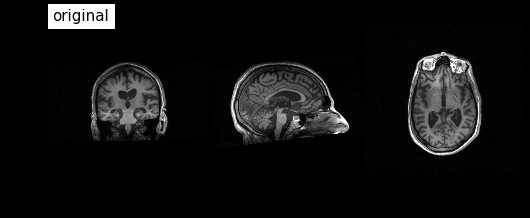

In [20]:
from nilearn.plotting import plot_anat
%matplotlib inline

plot_anat(input_t1, title='original',
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False);

In [21]:
from nipype.interfaces.fsl import BET
skullstrip = BET(in_file=input_t1,
                 out_file="/home/jscanass/brain/data/candela/Benhammou_S/T1w_nipype_bet.nii.gz",
                 mask=True, frac=0.7)
skullstrip.cmdline

190427-12:59:47,960 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


'bet /home/jscanass/brain/data/candela/Benhammou_S/t1_f20161205_133603t1mprtra320160cs018a1001.nii.gz /home/jscanass/brain/data/candela/Benhammou_S/T1w_nipype_bet.nii.gz -f 0.70 -m'

In [22]:
BET.help()

Wraps the executable command ``bet``.

FSL BET wrapper for skull stripping

For complete details, see the `BET Documentation.
<https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide>`_

Examples
--------
>>> from nipype.interfaces import fsl
>>> btr = fsl.BET()
>>> btr.inputs.in_file = 'structural.nii'
>>> btr.inputs.frac = 0.7
>>> btr.inputs.out_file = 'brain_anat.nii'
>>> btr.cmdline
'bet structural.nii brain_anat.nii -f 0.70'
>>> res = btr.run() # doctest: +SKIP

Inputs::

        [Mandatory]
        in_file: (an existing file name)
                input file to skull strip
                argument: ``%s``, position: 0

        [Optional]
        out_file: (a file name)
                name of output skull stripped image
                argument: ``%s``, position: 1
        outline: (a boolean)
                create surface outline image
                argument: ``-o``
        mask: (a boolean)
                create binary mask image
                argument: ``-m``
        skull: 

In [23]:
res = skullstrip.run()


OSError: No command "bet" found on host COMBIOS. Please check that the corresponding package is installed.

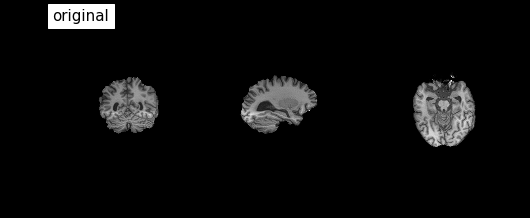

In [24]:
plot_anat("/home/jscanass/brain/data/candela/Benhammou_S/T1w_nipype_bet.nii.gz", title='original',
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False);

In [25]:
"/home/jscanass/brain/data/candela/Benhammou_S/T1w_nipype_bet.nii.gz"

/home/jscanass/.dipy/syn_test 
 /home/jscanass/.dipy/stanford_hardi 

SyntaxError: invalid syntax (<ipython-input-25-eeb4c10a44c8>, line 3)

In [ ]:
static_path = "/home/jscanass/.dipy/stanford_hardi/t1.nii.gz"
moving_pat = "/home/jscanass/.dipy/syn_test/nib_stanford"
Registration(static=static_path,moving=moving_path)

In [ ]:
static_path = "/home/jscanass/brain/data/candela/Benhammou_S/T1w_nipype_bet.nii.gz"
moving_path = input_dwi
Registration(static=static_path,moving=moving_path)

In [ ]:
# condición inicial (path o nibabel, revisar cómo lo hace dipy)
    
static_img = nib.load(static_path)
static = static_img.get_data()
static_grid2world = static_img.affine

moving_img = nib.load(moving_path)
moving = np.array(moving_img.get_data())
moving_grid2world = moving_img.affine

In [ ]:
import nibabel as nib

static_img = nib.load(input_t1)
static = static_img.get_data()
static_grid2world = static_img.affine

moving_img = nib.load(input_dwi)
moving = np.array(moving_img.get_data())[..., 0]
moving_grid2world = moving_img.affine

In [ ]:
type(static_img)

In [ ]:
type(static)

In [ ]:
np.shape(static)

In [ ]:
np.shape(static_grid2world)

In [ ]:
type(moving_img)

In [ ]:
type(moving)

In [ ]:
np.shape(moving)

In [ ]:
#datos dipy
nib_stanford, gtab_stanford = read_stanford_hardi()
static = np.squeeze(nib_stanford.get_data())[..., 0]
static_grid2world = nib_stanford.affine

nib_syn_t1, nib_syn_b0 = read_syn_data()
moving = np.array(nib_syn_b0.get_data())
moving_grid2world = nib_syn_b0.affine

In [ ]:
type(nib_stanford)

In [ ]:
type(gtab_stanford)

In [ ]:
type(static)

In [ ]:
np.shape(static)

In [ ]:
type(static_grid2world)

In [ ]:
np.shape(static_grid2world)

In [ ]:
type(nib_syn_t1)

In [ ]:
type(nib_syn_b0)

In [ ]:
type(moving)

In [ ]:
np.shape(moving)

In [ ]:
type(moving_grid2world)

In [ ]:
np.shape(moving_grid2world)

In [29]:
from nipype import Node, Workflow

from nilearn.plotting import plot_anat
%matplotlib inline
import matplotlib.pyplot as plt

In [30]:
from preprocessing.interfaces.Registration import Registration
registration = Node(Registration(out_file='t1_reg_node.nii.gz'), name='registration')

---> I. Translation of the moving image towards the static image
---> Resembling the moving image on a grid of the same dimensions as the static image


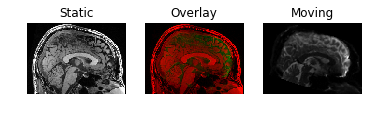

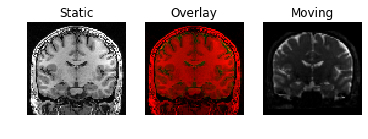

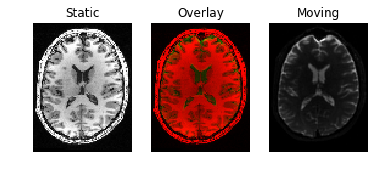

---> Aligning the centers of mass of the two images


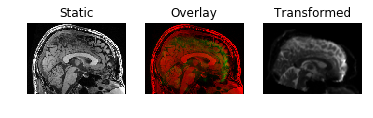

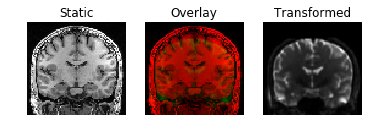

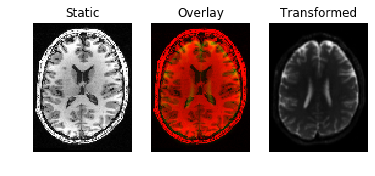

---> II. Refine  by looking for an affine transform
---> Computing Affine Registration (non-convex optimization)
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


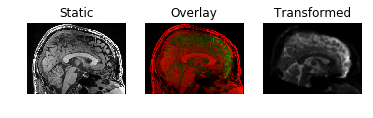

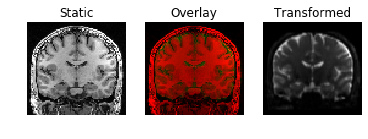

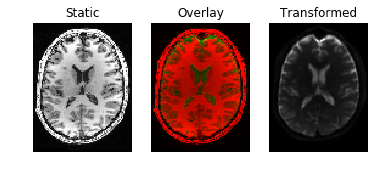

--->III. Refining with a rigid transform
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


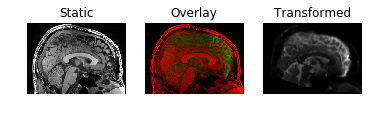

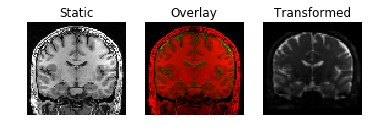

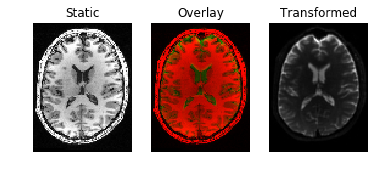

--->IV. Refining with a full afine transform (translation, rotation, scale and shear)
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


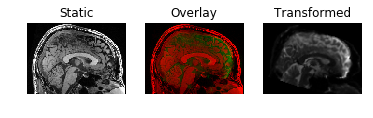

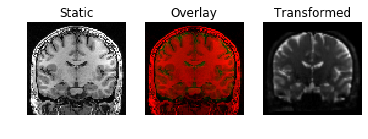

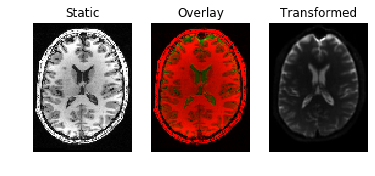

Total time:65.04351449012756
Translated file now is here: /home/jscanass/.dipy/stanford_hardi/regitration_nipype.nii.gz
Successfully affine registration applied


In [31]:
this_works = Registration(
    in_file="/home/jscanass/.dipy/stanford_hardi/HARDI150.nii.gz",
    static="/home/jscanass/.dipy/stanford_hardi/t1.nii.gz",
    out_file="/home/jscanass/.dipy/stanford_hardi/regitration_nipype.nii.gz")

result = this_works.run()

---> I. Translation of the moving image towards the static image
---> Resembling the moving image on a grid of the same dimensions as the static image


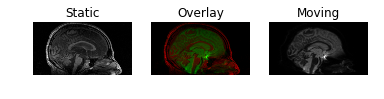

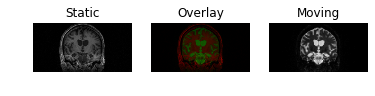

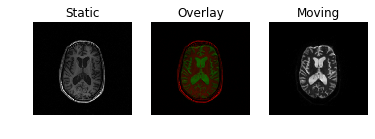

---> Aligning the centers of mass of the two images


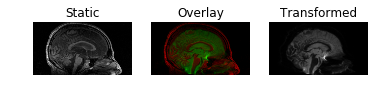

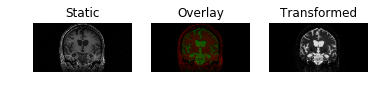

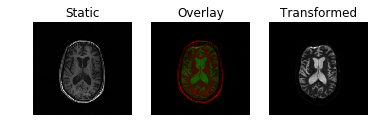

---> II. Refine  by looking for an affine transform
---> Computing Affine Registration (non-convex optimization)
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


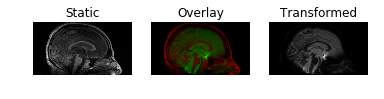

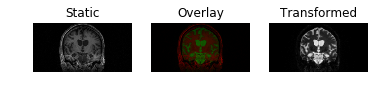

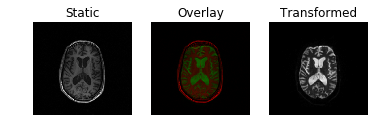

--->III. Refining with a rigid transform
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


KeyboardInterrupt: 

In [32]:
this_works = Registration(
    in_file="/home/jscanass/brain/data/candela/Benhammou_S/dwi_4Df20161205_133603DTI64dirStrictStricteISOs012a001_01.nii.gz",
    static="/home/jscanass/brain/data/candela/Benhammou_S/t1_f20161205_133603t1mprtra320160cs018a1001.nii.gz",
    out_file="/home/jscanass/brain/data/candela/Benhammou_S/regitration_nipype.nii.gz")

result = this_works.run()

In [ ]:
np.shape(transformed)